# File Info

Point of file is learning $\dot x = f_\theta(x(t), \lambda(t))$

Learning Standard Hopf Bifurcation with static bif parameter was completed in v2 

Moving to dynamic bifurcation parameter. 

In [6]:
from torchdiffeq import odeint as odeint

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider
import types

import Neural_ODEs_v1 as nodes
import DynamicalSystems as ds

# Data Geneation

Hopf Bifurcation

$\alpha > 0$ for supercritical

$\alpha < 0$ for subcritical

$$ 
\begin{aligned}
\dot r = r (\rho + \alpha r^2) \\
\dot \theta = \omega + \beta r^2
\end{aligned}
$$

fixed points at $r = 0$ and $r = \sqrt{\frac{-\rho}{\alpha}}$


In [7]:
class Hopf(ds.DynamicalSystem_torch):
    def __init__(self, rho=1.0, alpha=1.0, omega = 1.0, beta=1.0):
        super().__init__()
        self.rho = rho 
        self.alpha = alpha
        self.beta = beta
        self.omega = omega
        self.gamma = 0.1  # rate of evolution of non-autonomous parameter
        self.system_dim = 2


    def f(self, t, x): 
        #x sould be (traj, dim)
        if not isinstance(x, torch.Tensor):
            raise TypeError(f"Expected torch.Tensor, got {type(x)}")
        elif len(x.shape) == 1:
            if x.shape[0] != self.system_dim: 
                raise ValueError("x must have dimension of 2")
            else:
                x = x.unsqueeze(0)
        elif len(x.shape) == 2: 
            if x.shape[1] != self.system_dim: 
                raise ValueError("x.shape[1] must have dimension of ", self.system_dim)
        else:
            raise ValueError("Input tensor x cannot have more than 2 dimensions (trajectory, dimension)")
        
        xdot = self.rho * x[:, 0] - self.omega * x[:, 1] + (self.alpha*x[:, 0] - self.beta * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #traj
        ydot = self.omega * x[:, 0] + self.rho * x[:, 1] + (self.beta*x[:, 0] + self.alpha * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #(traj)
        return torch.cat([xdot.unsqueeze(1), ydot.unsqueeze(1)], dim = 1)
    
    def na_f(self, t, x):
        xdot = x[:, 2] * x[:, 0] - self.omega * x[:, 1] + (self.alpha*x[:, 0] - self.beta * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #traj
        ydot = self.omega * x[:, 0] + x[:, 2] * x[:, 1] + (self.beta*x[:, 0] + self.alpha * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #(traj)
        rdot = self.gamma * torch.ones_like(xdot)

        return torch.cat([xdot.unsqueeze(1), ydot.unsqueeze(1), rdot.unsqueeze(1)], dim = 1)

In [8]:
lc = Hopf(rho=1.0, alpha=-1.0, beta=0.0)
#Supercritical hopf 

In [9]:
y0 = torch.tensor([[1.0, 0.0, 1.0], [0.0, 1.0, 1.0], [0.0, 0.0, 1.0]])
y0.shape

torch.Size([3, 3])

In [10]:
lc.na_f(t = 0, x = y0).shape

torch.Size([3, 3])

In [11]:
sol = odeint(func=lc.na_f, y0=y0, t=torch.arange(0, 10, 0.1), method='rk4')

In [12]:
a = torch.arange(-2.0, 2.0, 0.5); b = torch.arange(-2, 2, 0.5); c = torch.ones_like(a)
ic = torch.cartesian_prod(a, b, torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0]))  #traj, dim


t_span = (0, 10); dt = 0.05
ic.shape #traj, dim


torch.Size([320, 3])

In [13]:
lc.f = lc.na_f

In [14]:
t_span

(0, 10)

In [15]:
sol = lc.solve(x0=ic, t_span=t_span, dt=dt) #(time, traj, dim  )


In [16]:
sol.shape

torch.Size([200, 320, 3])

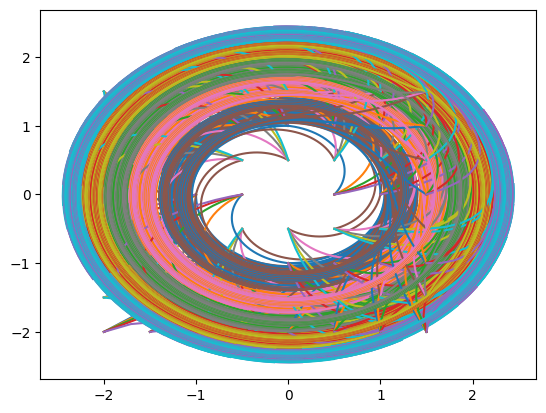

In [17]:
for i in range(ic.shape[0]):
    plt.plot(sol[:, i, 0], sol[:, i, 1])

In [18]:
training_data_tensor = sol.unsqueeze(0)
t_eval_tensor = torch.tensor( np.arange(t_span[0], t_span[1], dt), dtype=torch.float32 ).unsqueeze(0)

In [19]:
print(training_data_tensor.shape, t_eval_tensor.shape)

torch.Size([1, 200, 320, 3]) torch.Size([1, 200])


# Neural ODE - 

In [20]:
class NODE(nodes.Simple_FeedforwardNN):
    '''
    Class that creates an Neural ODE. 
    '''
    def __init__(self, input_dim: int, output_dim: int, depth: int, width: int, activation_func: nn.Module = nn.Tanh()):
        super().__init__(input_dim=input_dim, depth=depth, width=width, output_dim=output_dim, activation_func=activation_func)
        if input_dim < output_dim:
            raise ValueError("Input dimension must be greater than or equal to output dimension in a neural ODE.")
        else:
            self.width              = width #width is number of neurons per hidden layer
            self.depth              = depth #Number of internal hidden layers
            self.input_dim         = input_dim
            self.output_dim        = output_dim
            self.activation_func   = activation_func
    

    


    def forward(self, t, x): #x shoudl be (num_traj, spatial_dim)
        '''Takes t and x as input, where x is a pytorch tensor with shape: [trajectories, dim].'''
        out = self.network(x) #(num_traj, spatial_dim+drivers)
        return out

In [21]:
model = NODE(input_dim=lc.system_dim+1, output_dim=lc.system_dim+1, depth=5, width=20, activation_func=nn.Tanh())  

In [22]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()




In [23]:
num_epochs = 500
batch_size = 32
num_batches = 10

for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()

    # Predicting the trajectory
    pred_x_list = []
    for i in range(t_eval_tensor.shape[0]):
        pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :], t_eval_tensor[i, :], method='rk4', options={'step_size': dt})
        pred_x_list.append(pred_x_temp)

    pred_x = torch.stack(pred_x_list, dim=0)

    # Calculating loss
    loss = loss_fn(pred_x, training_data_tensor) 
    loss_list.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

  0%|          | 1/500 [00:00<07:53,  1.05it/s]

Epoch 0, Loss: 2.5987813472747803


  4%|▍         | 21/500 [00:19<07:51,  1.02it/s]

Epoch 20, Loss: 1.3070409297943115


  8%|▊         | 41/500 [00:38<07:42,  1.01s/it]

Epoch 40, Loss: 1.169197916984558


 12%|█▏        | 61/500 [00:57<06:59,  1.05it/s]

Epoch 60, Loss: 1.1042522192001343


 16%|█▌        | 81/500 [01:17<06:59,  1.00s/it]

Epoch 80, Loss: 1.0411947965621948


 20%|██        | 101/500 [01:44<09:40,  1.46s/it]

Epoch 100, Loss: 0.9334782958030701


 24%|██▍       | 121/500 [02:12<08:37,  1.37s/it]

Epoch 120, Loss: 0.7652307748794556


 28%|██▊       | 141/500 [02:38<08:00,  1.34s/it]

Epoch 140, Loss: 0.6783874034881592


 32%|███▏      | 161/500 [03:06<07:55,  1.40s/it]

Epoch 160, Loss: 0.5838562250137329


 36%|███▌      | 181/500 [03:34<07:14,  1.36s/it]

Epoch 180, Loss: 0.477963387966156


 40%|████      | 201/500 [04:01<06:50,  1.37s/it]

Epoch 200, Loss: 0.3667646050453186


 44%|████▍     | 221/500 [04:28<06:17,  1.35s/it]

Epoch 220, Loss: 0.25440704822540283


 48%|████▊     | 241/500 [04:46<03:08,  1.37it/s]

Epoch 240, Loss: 0.1509663313627243


 52%|█████▏    | 261/500 [05:03<03:22,  1.18it/s]

Epoch 260, Loss: 0.07907116413116455


 56%|█████▌    | 281/500 [05:18<02:36,  1.40it/s]

Epoch 280, Loss: 0.045707978308200836


 60%|██████    | 301/500 [05:34<02:42,  1.23it/s]

Epoch 300, Loss: 0.033784281462430954


 64%|██████▍   | 321/500 [05:55<03:35,  1.20s/it]

Epoch 320, Loss: 0.03145706281065941


 68%|██████▊   | 341/500 [06:23<03:41,  1.39s/it]

Epoch 340, Loss: 0.027966326102614403


 72%|███████▏  | 361/500 [06:45<01:49,  1.26it/s]

Epoch 360, Loss: 0.030620688572525978


 76%|███████▌  | 381/500 [07:07<02:38,  1.33s/it]

Epoch 380, Loss: 0.026765434071421623


 80%|████████  | 401/500 [07:34<02:10,  1.32s/it]

Epoch 400, Loss: 0.025969278067350388


 84%|████████▍ | 421/500 [08:00<01:43,  1.31s/it]

Epoch 420, Loss: 0.02454184927046299


 88%|████████▊ | 441/500 [08:27<01:19,  1.34s/it]

Epoch 440, Loss: 0.02341075986623764


 92%|█████████▏| 461/500 [08:54<00:53,  1.37s/it]

Epoch 460, Loss: 0.025267837569117546


 96%|█████████▌| 481/500 [09:22<00:25,  1.36s/it]

Epoch 480, Loss: 0.025872986763715744


100%|██████████| 500/500 [09:48<00:00,  1.18s/it]


In [24]:
# Analysis of Trained Model

In [ ]:
model.gamma

Text(0.5, 0, 'Epochs')

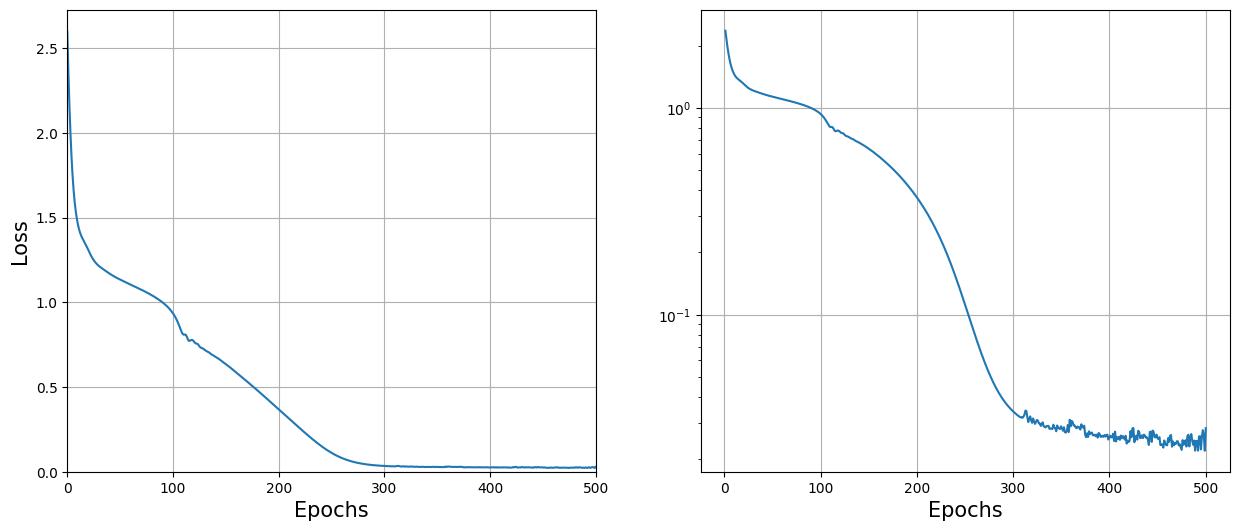

In [33]:
### Analysis  
epochs = len(loss_list)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])

#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [34]:
r_vals = torch.arange(-1.0, 10.0, 0.1)

r_vals.shape

torch.Size([110])

In [58]:
a = torch.linspace(-2, 2, 10)  
b = torch.linspace(-2, 2, 10)  

pts = torch.cartesian_prod(a, b, r_vals)


t_Start_pred = 0; t_Final_pred = 20; dt_pred = 0.05
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt_pred)
model.gamma = 0.0  # rate of evolution of non-autonomous parameter
node_data = odeint(model, pts.float(), t_eval_pred, method='rk4', options={'step_size': dt_pred})
true_data = odeint(func=lc.na_f, y0=pts, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})

#Plotting results
fig = plt.figure(figsize=(10, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1)
for i in range(pts.shape[0]):
    ax1.arrow(x=true_data[0, i, 0].detach().numpy(), y=true_data[0, i, 1].detach().numpy(), 
          dx=true_data[10, i, 0].detach().numpy() - true_data[0, i, 0].detach().numpy(), 
          dy=true_data[10, i, 1].detach().numpy() - true_data[0, i, 1].detach().numpy(), length_includes_head=True, head_width=0.05, head_length=0.1, color='gray')


#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2)
for i in range(pts.shape[0]):
    ax2.arrow(x=node_data[0, i, 0].detach().numpy(), y=node_data[0, i, 1].detach().numpy(), 
          dx=node_data[10, i, 0].detach().numpy() - node_data[0, i, 0].detach().numpy(), 
          dy=node_data[10, i, 1].detach().numpy() - node_data[0, i, 1].detach().numpy(), length_includes_head=True, head_width=0.05, head_length=0.1, color='gray')

    



plt.show()

In [55]:
node_data[:, pts[:, 2] == -1, :]

tensor([[[-2.0000, -2.0000, -1.0000],
         [-2.0000, -1.5556, -1.0000],
         [-2.0000, -1.1111, -1.0000],
         ...,
         [ 2.0000,  1.1111, -1.0000],
         [ 2.0000,  1.5556, -1.0000],
         [ 2.0000,  2.0000, -1.0000]],

        [[-1.8417, -2.0111, -0.9935],
         [-1.8567, -1.5748, -0.9942],
         [-1.8811, -1.1451, -0.9949],
         ...,
         [ 1.8935,  1.1477, -0.9963],
         [ 1.8701,  1.5725, -0.9980],
         [ 1.8550,  2.0060, -0.9999]],

        [[-1.6844, -2.0224, -0.9871],
         [-1.7141, -1.5939, -0.9887],
         [-1.7617, -1.1774, -0.9898],
         ...,
         [ 1.7871,  1.1821, -0.9925],
         [ 1.7421,  1.5891, -0.9959],
         [ 1.7124,  2.0121, -0.9996]],

        ...,

        [[-0.3301,  0.0686, -0.1425],
         [-0.3091,  0.0453, -0.1305],
         [-0.2927,  0.0558, -0.1203],
         ...,
         [ 0.2783,  0.0433, -0.0698],
         [ 0.2931,  0.1245, -0.1126],
         [ 0.2958,  0.1833, -0.1614]],

        [[

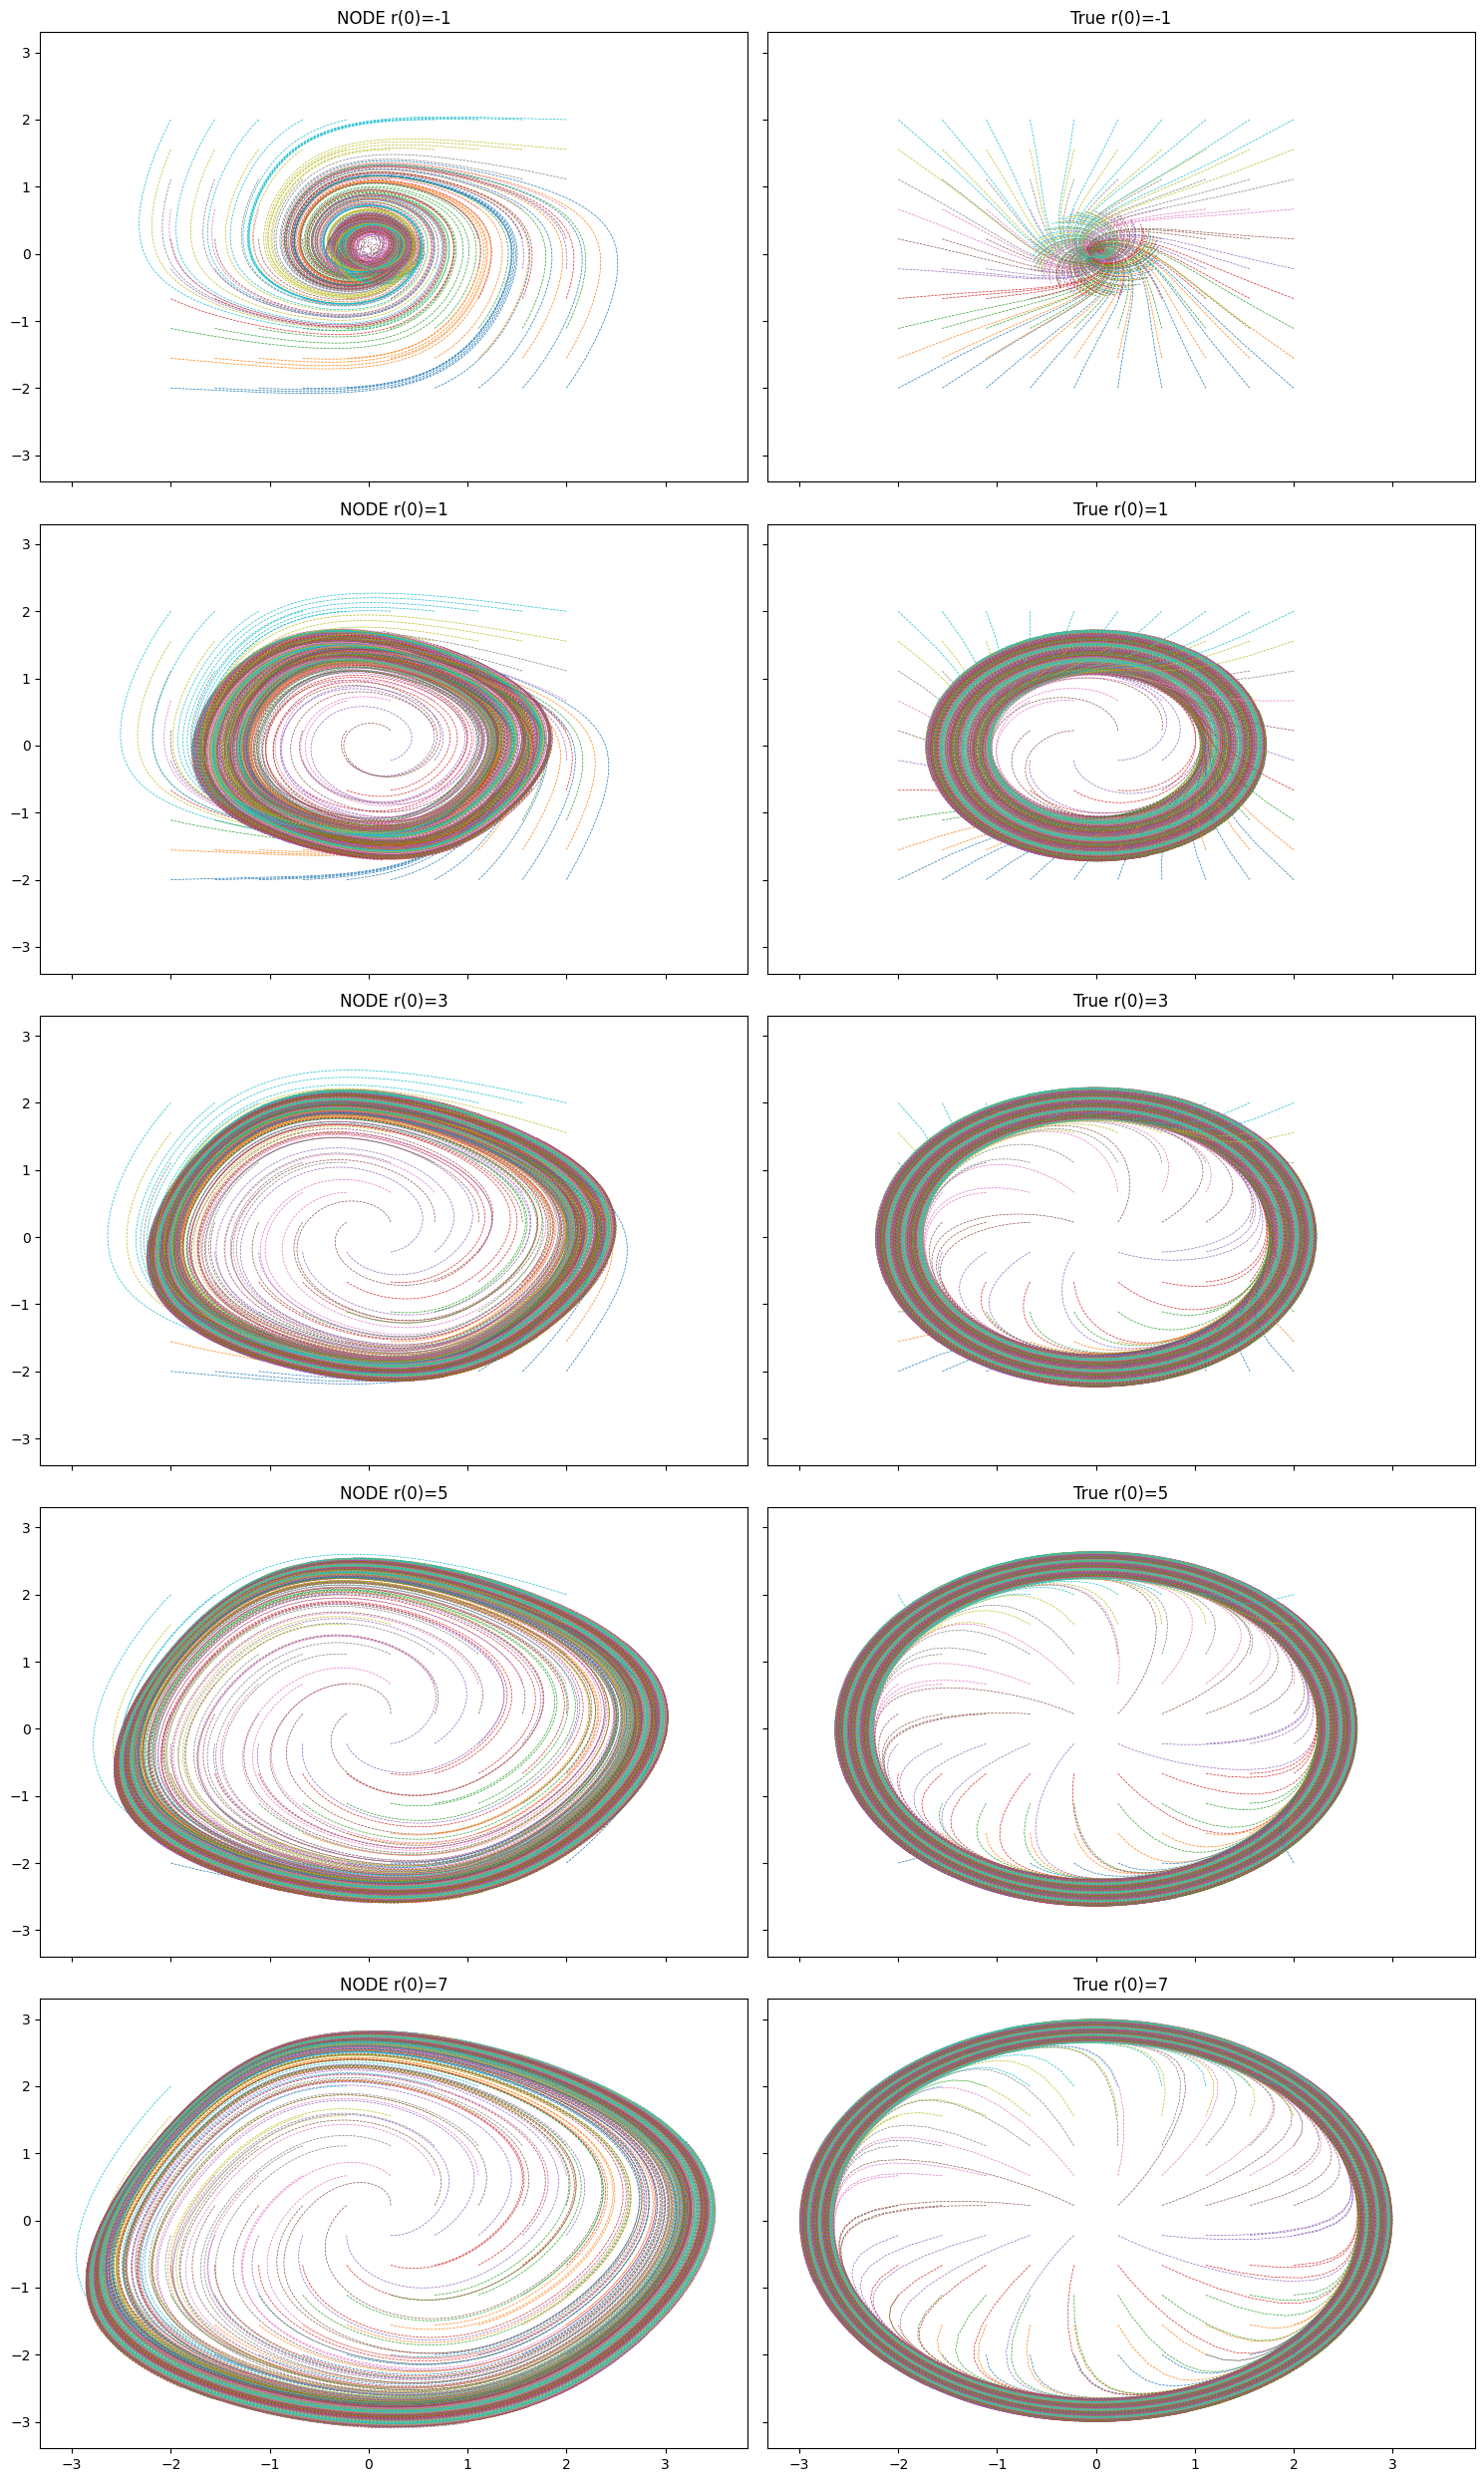

In [66]:
r_plots = [-1, 1, 3, 5, 7]
fig, axes = plt.subplots(len(r_plots), 2, figsize=(15, 5*len(r_plots)), sharex=True, sharey=True)

for i, r in enumerate(r_plots):
    axes[i, 0].plot(node_data[:, pts[:, 2] == r, 0].detach().numpy(),
                    node_data[:, pts[:, 2] == r, 1].detach().numpy(),
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 1].plot(true_data[:, pts[:, 2] == r, 0].detach().numpy(),
                    true_data[:, pts[:, 2] == r, 1].detach().numpy(),
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 0].set_title(f"NODE r(0)={r}")
    axes[i, 1].set_title(f"True r(0)={r}")

plt.tight_layout()
plt.show()

In [39]:
pts.shape

torch.Size([11000, 3])

In [40]:
# Interactive trajectory plot
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

def plot_traj(idx=0):
    fig = plt.figure(figsize=(15, 8))
    r_val = r_vals[idx]
    print('rho = ', r_val.float())
    #First Plot
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(node_data[:, pts[:, 2] == r_val, 0].detach().numpy(), node_data[:, pts[:, 2] == r_val, 1].detach().numpy(), linewidth=0.5, alpha=1, linestyle='--')

    ax1 = fig.add_subplot(1, 2, 2)
    ax1.plot(true_data[:, pts[:, 2] == r_val, 0].detach().numpy(), true_data[:, pts[:, 2] == r_val, 1].detach().numpy(), linewidth=0.5, alpha=1, linestyle='--')


In [41]:
interact(plot_traj, idx=IntSlider(min=0.0, max=r_vals.shape[0]-1, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=109), Output()), _dom_classes=('widget-interac…

<function __main__.plot_traj(idx=0)>